# AUTOENCODER MICRO SPRITE GENERATOR
Tests architecture for micro sprite generation using autoencoders, variational autoencoders, and vq-vaes

---

### Setup

In [674]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import os
import json
from matplotlib.colors import ListedColormap

# tensorflow
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, Conv2DTranspose, Flatten, Layer, Reshape, Input, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model


%matplotlib inline

CONSTANTS and GLOBALS

In [8]:
# CONSTANT VARIABLES

# PICO-8 Palette => use colormap for matplotlib
PICO_PALETTE = ['#000000','#1D2B53','#7E2553','#008751','#AB5236','#5F574F','#C2C3C7','#FFF1E8','#FF004D','#FFA300','#FFEC27','#00E436','#29ADFF','#83769C','#FF77A8','#FFCCAA']


GENERAL UTILITY FUNCTIONS

In [9]:
##  RENDER FUNCTIONS  ##

# show a single sprite - using a specified palette (form (NxN))
def showSprPalette(spr,palette=PICO_PALETTE):
    #set the colormap
    colormap = ListedColormap(palette,N=len(palette))

    #show the sprite
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(spr.squeeze(),cmap=colormap,vmin=0,vmax=len(palette)-1)
    plt.show()


# show a list of sprites - using a specified palette (form Ax(NxN))
def showMultiSprPalette(sprs,palette=PICO_PALETTE,text='',textArr=None):
    #set the colormap
    colormap = ListedColormap(palette,N=len(palette))

    #show sprites (8 per row)
    plt.figure(figsize=(20,7))
    col = 8
    for i, im in enumerate(sprs):
        plt.subplot(int(len(sprs) / col) + 1, col, i + 1)
        plt.imshow(im.squeeze(),cmap=colormap,vmin=0,vmax=len(palette)-1)
        plt.axis('off')

        #add sublabels
        if (textArr != None) and (i < len(textArr)):
            addtext = ""
            #sub label + title on middle entry
            if text != '' and i == (min(len(sprs),col)//2):
                addtext = f"{text.upper()}\n"
            plt.title(f"{addtext}{textArr[i]}")
            
        #add plot title only
        else:
            if text != '' and i == (min(len(sprs),col)//2):
                plt.title(text.upper())
    plt.show()

# show a single sprite - using RGB (form (NxNx3))
def showSprRGB(spr):
    #show the sprite
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow(spr.squeeze())
    plt.show()

# show a list of sprites - using RGB (form Ax(NxNx3))
def showMultiSprRGB(sprs,text='',textArr=None):
    #show sprites (8 per row)
    plt.figure(figsize=(20,7))
    col = 8
    for i, im in enumerate(sprs):
        plt.subplot(int(len(sprs) / col) + 1, col, i + 1)
        plt.imshow(im.squeeze())
        plt.axis('off')

        #add sublabels
        if (textArr != None) and (i < len(textArr)):
            addtext = ""
            #sub label + title on middle entry
            if text != '' and i == (min(len(sprs),col)//2):
                addtext = f"{text.upper()}\n"
            plt.title(f"{addtext}{textArr[i]}")
            
        #add plot title only
        else:
            if text != '' and i == (min(len(sprs),col)//2):
                plt.title(text.upper())
    plt.show()




##  DATA PROCESSING FUNCTIONS  ##

# encode a sprite to one-hot array based on a palette (form (NxN) => (NxNxP)))
def encodeSpr1H(s,channels=len(PICO_PALETTE)):
    spr3d = np.zeros((s.shape[0],s.shape[1],channels))
    for r in range(s.shape[0]):
        for c in range(s.shape[1]):
            v = s[r][c]
            spr3d[r][c][v] = 1
    return spr3d
    
#convert 3d encoded channel map into 2d array format
def decodeSpr1H(s3c):
    return np.argmax(s3c,axis=2)
    

IMPORT DATASETS

Food Dataset shape: (100, 8, 8)
Char Dataset shape: (100, 8, 8)


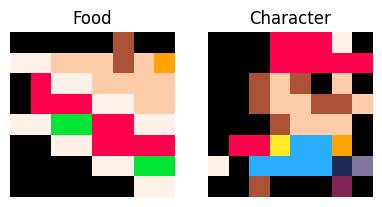

In [10]:
# import from the PICO sprites posted onto Twitter 
# Food: https://twitter.com/JUSTIN_CYR/status/634546317713391616
# Characters: https://twitter.com/johanvinet/status/635814153601597441
pico_food_dat = np.load('../data/rip_data/pico_food.npy',allow_pickle=True)
pico_char_dat = np.load('../data/rip_data/pico_characters.npy',allow_pickle=True)

print(f"Food Dataset shape: {pico_food_dat.shape}")
print(f"Char Dataset shape: {pico_char_dat.shape}")

# show a random food and character sprite 
rand_food = random.choice(pico_food_dat)
rand_char = random.choice(pico_char_dat)
showMultiSprPalette([rand_food,rand_char],textArr=['Food','Character'])

### GENERATIVE MODEL EXPERIMENT 

#### Autoencoder Experiments
Needs to overfit for such a small dataset (train 350 epochs or so)

In [11]:
TRAIN_AE = False
AE_MODEL_NAME = "pico_ae-[char100p]-350"  #if not retraining, specify the model name to load

In [12]:
##  BASIC AUTOENCODER  ##

class PICOAutoencoder(Model):
    def __init__(self,in_shape,show_summary=False):
        super(PICOAutoencoder, self).__init__()
        self.encoder = Sequential([
            InputLayer(input_shape=in_shape),
            Conv2D(64, (2,2), strides=2, activation='relu', padding='same'),
            Conv2D(32, (2,2), strides=2, activation='relu', padding='same'),
            Conv2D(16, (2,2), strides=2, activation='relu', padding='same')])

        self.decoder = Sequential([
            InputLayer(input_shape=self.encoder.output_shape[1:]),
            Conv2DTranspose(16, (2,2), strides=2, activation='relu', padding='same'),
            Conv2DTranspose(32, (2,2), strides=2, activation='relu', padding='same'),
            Conv2DTranspose(64, (2,2), strides=2, activation='relu', padding='same'),
            # Conv2D(in_shape[-1], (3,3), activation='sigmoid', padding='same')])
            Conv2D(in_shape[-1], (3,3), activation='softmax', padding='same')])
        

        if show_summary:
            print("== ENCODER ==")
            self.encoder.summary()
            print("")
            print("== DECODER ==")
            self.decoder.summary()
        

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def exportEnc(self, name):
        if not os.path.exists("../models/gen_models/autoencoders/"):
            os.mkdir("../models/gen_models/autoencoders/")
        self.encoder.save(f"../models/gen_models/autoencoders/{name}_encoder.h5")

    def exportDec(self, name):
        if not os.path.exists("../models/gen_models/autoencoders/"):
            os.mkdir("../models/gen_models/autoencoders/")
        self.decoder.save(f"../models/gen_models/autoencoders/{name}_decoder.h5")

    def importDec(self,name):
        self.decoder = load_model(f"../models/gen_models/autoencoders/{name}_decoder.h5")
        
    def importEnc(self,name):
        self.encoder = load_model(f"../models/gen_models/autoencoders/{name}_encoder.h5")

In [13]:
# setup the dataset
# pico_ae_dat = np.concatenate((pico_food_dat,pico_char_dat),axis=0)  # combine food and character datasets
pico_ae_dat = pico_char_dat

pico_ae_dat = np.array([encodeSpr1H(s) for s in pico_ae_dat])   # encode to 1-hot
np.random.shuffle(pico_ae_dat)                                  # shuffle the dataset
print(f"Autoencoder Dataset shape: {pico_ae_dat.shape}")

# setup the model
pico_ae_model = PICOAutoencoder((8,8,len(PICO_PALETTE)),True)
# pico_ae_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
pico_ae_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model (if TRAIN_AE is True) otherwise load the model
EPOCHS = 250
BATCH_SIZE = 16
if TRAIN_AE:
    h = pico_ae_model.fit(pico_ae_dat, pico_ae_dat, batch_size=BATCH_SIZE,epochs=EPOCHS,shuffle=True)

    #plot the accuracy over time
    plt.plot(h.history['accuracy'])
else:
    print(f"Loading model: {AE_MODEL_NAME}")
    pico_ae_model.importEnc(AE_MODEL_NAME)
    pico_ae_model.importDec(AE_MODEL_NAME)


Autoencoder Dataset shape: (100, 8, 8, 16)
== ENCODER ==
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 4, 64)          4160      
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 32)          8224      
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 16)          2064      
                                                                 
Total params: 14,448
Trainable params: 14,448
Non-trainable params: 0
_________________________________________________________________

== DECODER ==
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 2, 2, 16)         1040      
 nspose)                

2023-03-28 17:50:41.351558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


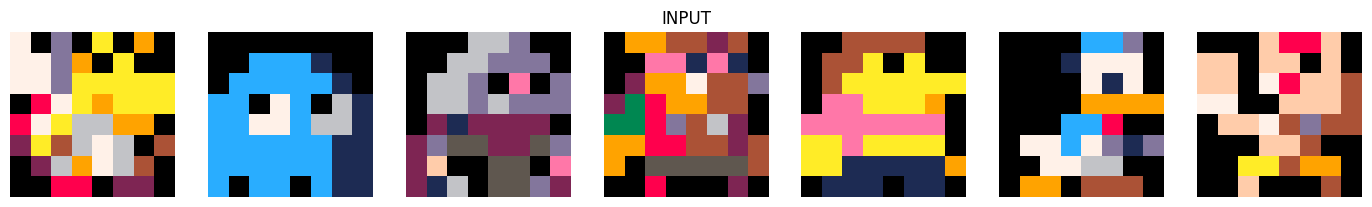

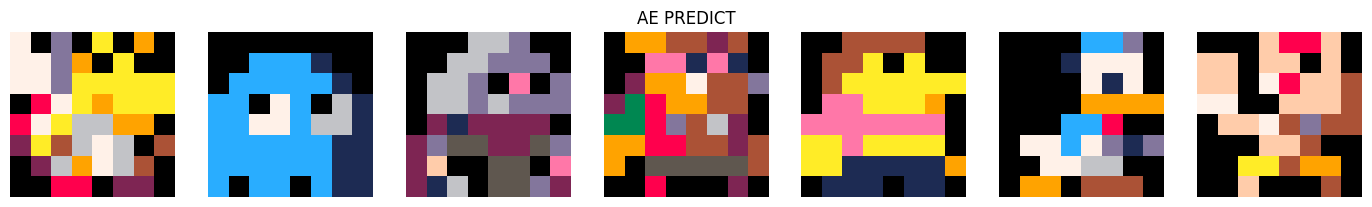

In [14]:
# test output
ae_test_set = random.choices(pico_ae_dat, k=7)
ae_test_set = np.array(ae_test_set)

showMultiSprPalette([decodeSpr1H(s) for s in ae_test_set],text='INPUT')
showMultiSprPalette([decodeSpr1H(s) for s in pico_ae_model.predict(ae_test_set,verbose=False)],text='AE PREDICT')


(7, 1, 1, 16)


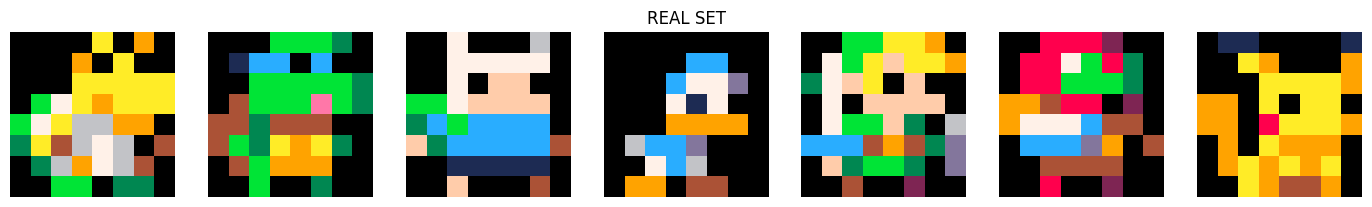

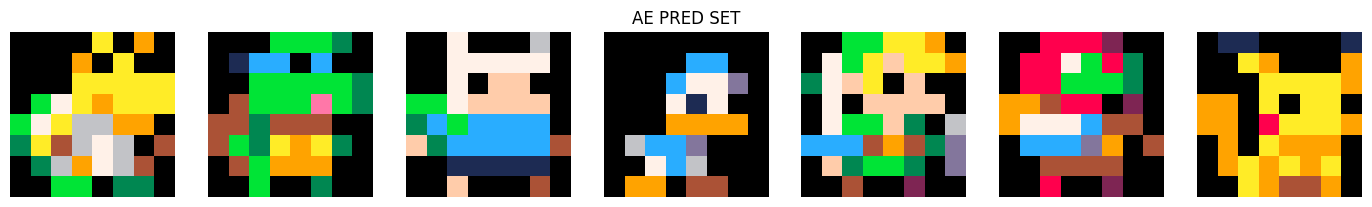

In [15]:
# random sampling

# show some final outputs from real data
real_set = [7,30,53,86,90,96,99]    
real_set_label = ['Koopa','Donatello','Finn','Dewey','Link','Samus','Pikachu']
real_oh_set = np.array([encodeSpr1H(s) for s in pico_char_dat[real_set]])

real_enc = pico_ae_model.encoder.predict(real_oh_set,verbose=False)
real_dec = pico_ae_model.decoder.predict(real_enc,verbose=False)

print(real_enc.shape)

showMultiSprPalette([pico_char_dat[i] for i in real_set],text='Real set')
showMultiSprPalette([decodeSpr1H(s) for s in real_dec],text='AE Pred set')


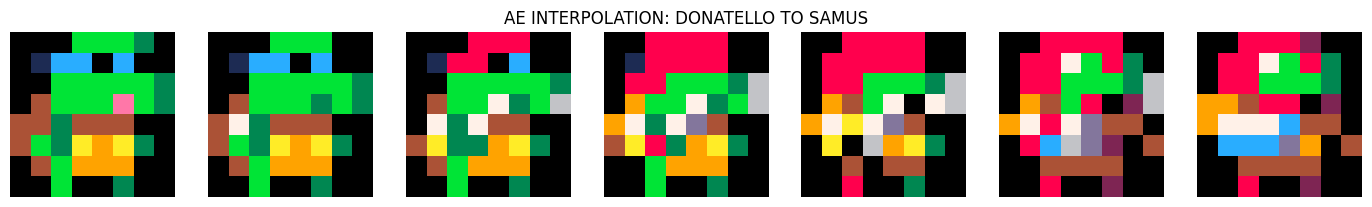

In [16]:
# shift from one character to another

def interpolateVec(v1,v2,steps):
    return [v1 + (v2-v1)*i/(steps-1) for i in range(steps)]

pick2 = random.sample(range(len(real_enc)), k=2)
inter_vec = interpolateVec(real_enc[pick2[0]],real_enc[pick2[1]],7) 
inter_pred = pico_ae_model.decoder.predict(np.array(inter_vec),verbose=False)
showMultiSprPalette([decodeSpr1H(s) for s in inter_pred],text=f'AE Interpolation: {real_set_label[pick2[0]]} to {real_set_label[pick2[1]]}')


In [17]:
# compare between 2 groups of similar characters (ninja turtles + duck tales)
ninja_turtles = [30,31,32,33]
duck_tales = [84,85,86,87]

ninja_oh = np.array([encodeSpr1H(s) for s in pico_char_dat[ninja_turtles]])
duck_oh = np.array([encodeSpr1H(s) for s in pico_char_dat[duck_tales]])

ninja_enc = pico_ae_model.encoder.predict(ninja_oh,verbose=False)
duck_enc = pico_ae_model.encoder.predict(duck_oh,verbose=False)

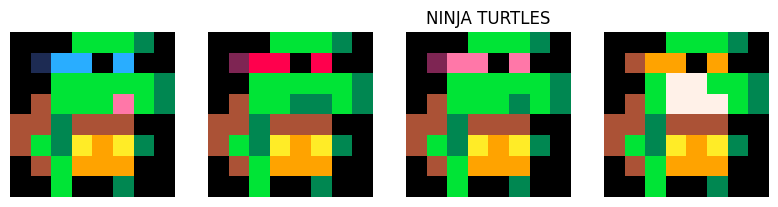

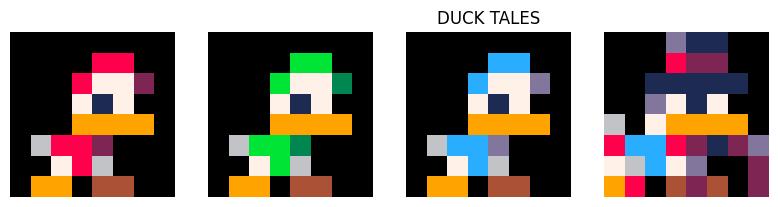

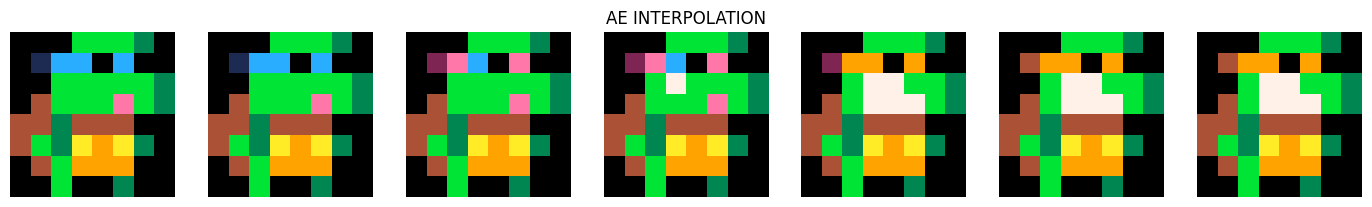

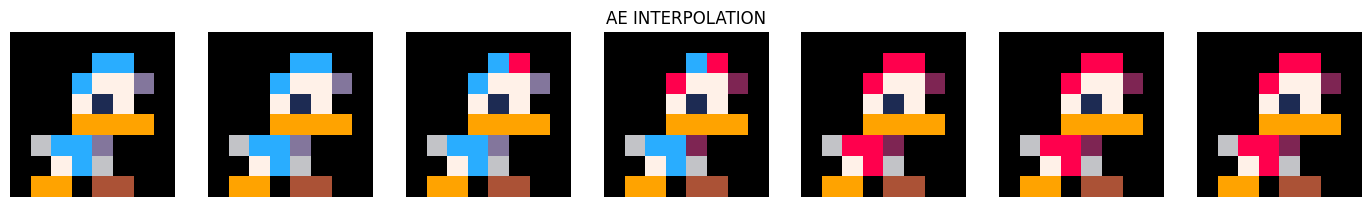

In [18]:
showMultiSprPalette([pico_char_dat[i] for i in ninja_turtles],text='Ninja Turtles')
showMultiSprPalette([pico_char_dat[i] for i in duck_tales],text='Duck Tales')

# interpolate between 2 random turtles and 2 random ducks
for a in [ninja_enc,duck_enc]:
    pick2 = random.sample(range(len(a)), k=2)
    inter_vec = interpolateVec(a[pick2[0]],a[pick2[1]],7)
    inter_pred = pico_ae_model.decoder.predict(np.array(inter_vec),verbose=False)
    showMultiSprPalette([decodeSpr1H(s) for s in inter_pred],text=f'AE Interpolation')

In [19]:
# retrieve range of each element from the encoding vector 
enc_vec_set = pico_ae_model.encoder.predict(pico_ae_dat,verbose=False)
enc_vec_min_max = np.array([[np.min(enc_vec_set[:,:,i,j]),np.max(enc_vec_set[:,:,i,j])] for i in range(enc_vec_set.shape[2]) for j in range(enc_vec_set.shape[3])])

print(enc_vec_min_max.shape)  #should be (1,16,2)
print(enc_vec_min_max)
 


(16, 2)
[[  0.93523026 222.0659    ]
 [  0.         173.56053   ]
 [  2.0184238  273.97604   ]
 [  0.         212.41785   ]
 [  0.         311.12335   ]
 [  0.           0.        ]
 [  0.         232.72699   ]
 [  2.9373052  298.1779    ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  1.5205781  224.14082   ]
 [  0.50582504 198.08095   ]
 [  0.           0.        ]
 [  0.         264.87955   ]
 [  0.          85.15058   ]
 [  0.           0.        ]]


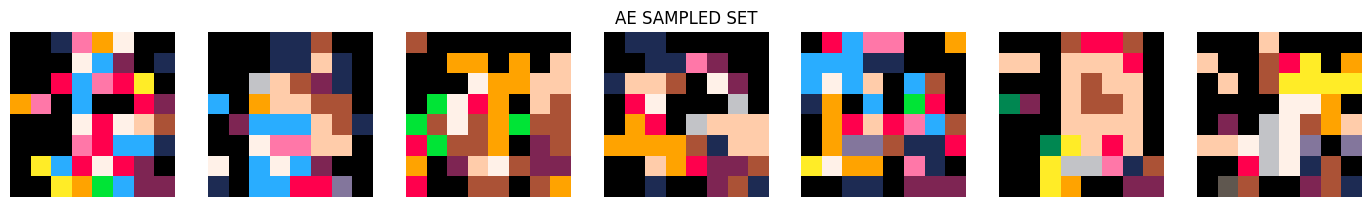

In [20]:
# sample from this space and show output
sample_set = []
for i in range(7):
    sample = np.array([np.random.uniform(enc_vec_min_max[i][0],enc_vec_min_max[i][1]) for i in range(16)])
    sample = np.expand_dims(sample,0)
    sample = np.expand_dims(sample,0)
    sample_set.append(sample)
sample_set = np.array(sample_set)
pred_samp_set = pico_ae_model.decoder.predict(sample_set,verbose=False)

showMultiSprPalette([decodeSpr1H(s) for s in pred_samp_set],text='AE Sampled set')


In [21]:
# export the model
pico_ae_model.exportEnc(f'pico_ae-[char100p]-{EPOCHS}')
pico_ae_model.exportDec(f'pico_ae-[char100p]-{EPOCHS}')

#### VARIATIONAL AUTOENCODER

In [54]:
# CONSTANTS

TRAIN_VAE = False
VAE_MODEL_NAME = "pico_vae-[char]-1000"
vae_dataset_type = "char"  #char, food, or both
EXPORT_VAE = False

VAE_Z = 16
VAE_EPOCHS = 750
VAE_BATCH_SIZE = 8

In [58]:
##  BASIC VAE  ##

class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    


class PICOVAE(Model):
    def __init__(self,nn_shape,zshape=16,show_summary=False):
        super(PICOVAE, self).__init__()
        
        self.spr_shape = nn_shape
        self.latent_dim = zshape
        
        #make the models
        self.makeEncoder(show_summary)
        self.makeDecoder(show_summary)
        
        
    #makes the encoder model for the VAE
    def makeEncoder(self,show_summary=False):
        
        #variational encoder
        enc_in = Input(shape=self.spr_shape)
        x = Conv2D(32, (2,2), activation=LeakyReLU(), padding='same', strides=2)(enc_in)
        x = Conv2D(64, (2,2), activation=LeakyReLU(), padding='same', strides=2)(x)
        x = Flatten()(x)
        x = Dense(16, activation='relu')(x)
        
        #variational sampling
        z_mean = Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
            
        #combine together
        self.encoder = Model(enc_in, [z_mean, z_log_var, z], name='encoder')
        
        if show_summary:
            self.encoder.summary()
        
    #makes the decoder model for the VAE
    def makeDecoder(self,show_summary=False):
        #normal decoder
        dec_in = Input(shape=(self.latent_dim,))
        y = Dense(2*2*64, activation="relu")(dec_in)  #product of output shape of encoder model
        y = Reshape((2,2,64))(y)  #output shape of encoder model before flattening
        y = Conv2DTranspose(64, kernel_size=2, strides=2, activation=LeakyReLU(), padding='same')(y)
        y = Conv2DTranspose(32, kernel_size=2, strides=2, activation=LeakyReLU(), padding='same')(y)
        dec_out = Conv2DTranspose(16, kernel_size=(3, 3), activation='softmax', padding='same')(y)  #softmax to get 1-hot encoding
        self.decoder = Model(dec_in, dec_out)

        
        if show_summary:
            self.decoder.summary()

    # training step for VAE
    def train_step(self, data):    
        with tf.GradientTape() as tape:
            #get output encoding and reconstruct from latent vector
            z_mean, z_log_var, z = self.encoder(data)

            # reconstructive loss
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.categorical_crossentropy(data, reconstruction), axis=(1, 2)   #categorical cross-entropy because one-hot encoded
                )
            )

            # KL divergence loss
            kl = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl = tf.reduce_mean(tf.reduce_sum(kl, axis=1))

            #total loss
            tl = reconstruction_loss + kl
             
        #apply loss back to weights
        grads = tape.gradient(tl, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {"recon loss":reconstruction_loss, "kl loss":kl, "total loss": tl}
    
    #custom reconstruction function
    def reconstruct(self, data, **kwargs):
        _, _, z = self.encoder.predict(data,**kwargs)
        reconstruction = self.decoder.predict(z,**kwargs)
        return reconstruction
    
    #custom encoding function
    def decodeZ(self, z, **kwargs):
        return self.decoder.predict(z,**kwargs)
    

    #### EXPORT/IMPORT  ####
    
    def exportEnc(self, name):
        if not os.path.exists("../models/gen_models/vaes/"):
            os.mkdir("../models/gen_models/vaes/")
        self.encoder.save(f"../models/gen_models/vaes/{name}_encoder.h5")

    def exportDec(self, name):
        if not os.path.exists("../models/gen_models/vaes/"):
            os.mkdir("../models/gen_models/vaes/")
        self.decoder.save(f"../models/gen_models/vaes/{name}_decoder.h5")

    def importDec(self,name):
        self.decoder = load_model(f"../models/gen_models/vaes/{name}_decoder.h5",custom_objects={"Sampling":Sampling})
        
    def importEnc(self,name):
        self.encoder = load_model(f"../models/gen_models/vaes/{name}_encoder.h5",custom_objects={"Sampling":Sampling})

In [59]:
# setup the dataset
if vae_dataset_type == "char":
    pico_vae_dat = pico_char_dat
elif vae_dataset_type == "food":
    pico_vae_dat = pico_food_dat
else:
    pico_ae_dat = np.concatenate((pico_food_dat,pico_char_dat),axis=0)  # combine food and character datasets

pico_vae_dat = np.array([encodeSpr1H(s) for s in pico_vae_dat])   # encode to 1-hot
np.random.shuffle(pico_vae_dat)                                  # shuffle the dataset
print(f"Autoencoder Dataset shape: {pico_vae_dat.shape}")

# setup the VAE model
pico_vae_model = PICOVAE((8,8,len(PICO_PALETTE)),VAE_Z,True)

# train the model if TRAIN_VAE is True else load the model
if TRAIN_VAE:
    pico_vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))
    vaeh = pico_vae_model.fit(pico_vae_dat,epochs=VAE_EPOCHS,batch_size=VAE_BATCH_SIZE,shuffle=True,verbose=True)
else: 
    pico_vae_model.importEnc(VAE_MODEL_NAME)
    pico_vae_model.importDec(VAE_MODEL_NAME)


Autoencoder Dataset shape: (100, 8, 8, 16)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 8, 8, 16)]   0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 4, 4, 32)     2080        ['input_9[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 2, 2, 64)     8256        ['conv2d_10[0][0]']              
                                                                                                  
 flatten_3 (Flatten)            (None, 256)          0           ['conv2d_11[0][0]']              
                                                 

In [63]:
pico_vae_dat.shape

(100, 8, 8, 16)

In [60]:
#plot the accuracy over time
if TRAIN_VAE:
    plt.plot(vaeh.history['recon loss'],label='recon loss')
    plt.plot(vaeh.history['kl loss'],label='kl loss')
    plt.plot(vaeh.history['total loss'],label='total loss')
    plt.legend()

    plt.show()

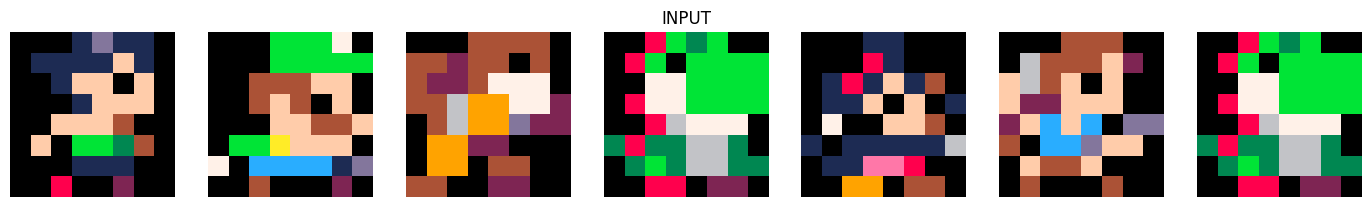

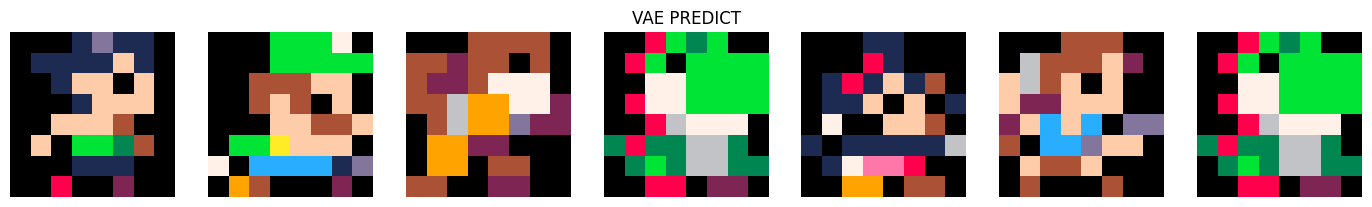

In [61]:
# test output
vae_test_set = random.choices(pico_vae_dat, k=7)
vae_test_set = np.array(vae_test_set)

showMultiSprPalette([decodeSpr1H(s) for s in vae_test_set],text='INPUT')
showMultiSprPalette([decodeSpr1H(s) for s in pico_vae_model.reconstruct(vae_test_set,verbose=False)],text='VAE PREDICT')


(7, 16)


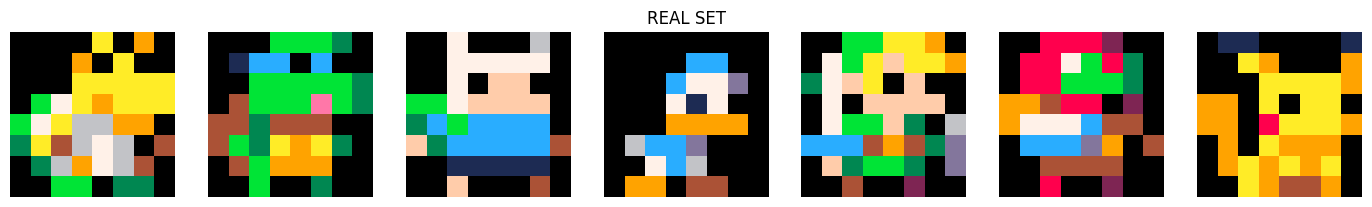

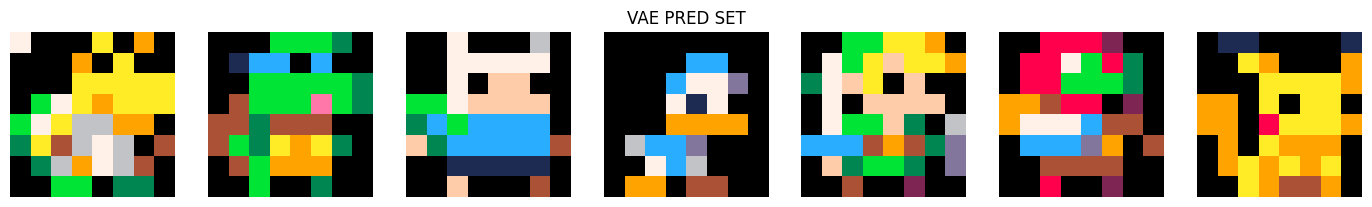

In [ ]:
# random sampling

if vae_dataset_type == "char":
    # show some final outputs from real data
    real_set = [7,30,53,86,90,96,99]    
    real_set_label = ['Koopa','Donatello','Finn','Dewey','Link','Samus','Pikachu']
    real_oh_set = np.array([encodeSpr1H(s) for s in pico_char_dat[real_set]])

    _,_,real_enc_z = pico_vae_model.encoder.predict(real_oh_set,verbose=False)
    real_dec = pico_vae_model.decoder.predict(real_enc_z,verbose=False)

    print(real_enc_z.shape)

    showMultiSprPalette([pico_char_dat[i] for i in real_set],text='Real set')
    showMultiSprPalette([decodeSpr1H(s) for s in real_dec],text='VAE Pred set')

elif vae_dataset_type == "food":
    # show some final outputs from real data
    real_set = [2,6,7,11,27,38,63]    
    real_set_label = ['Banana', "Watermelon", "Cherry", "Beer", "Pretzel", "Blue Popsicle", "Pizza"]
    real_oh_set = np.array([encodeSpr1H(s) for s in pico_food_dat[real_set]])

    _,_,real_enc_z = pico_vae_model.encoder.predict(real_oh_set,verbose=False)
    real_dec = pico_vae_model.decoder.predict(real_enc_z,verbose=False)

    print(real_enc_z.shape)

    showMultiSprPalette([pico_food_dat[i] for i in real_set],text='Real set')
    showMultiSprPalette([decodeSpr1H(s) for s in real_dec],text='VAE Pred set')


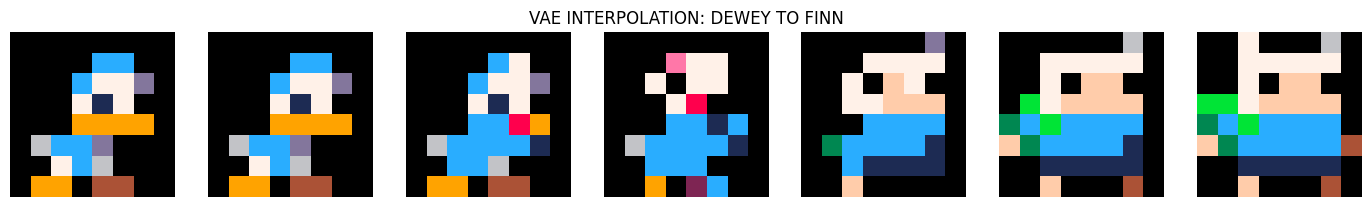

In [ ]:
# shift from one character to another

def interpolateVec(v1,v2,steps):
    return [v1 + (v2-v1)*i/(steps-1) for i in range(steps)]

pick2 = random.sample(range(len(real_enc_z)), k=2)
inter_vec = interpolateVec(real_enc_z[pick2[0]],real_enc_z[pick2[1]],7) 
inter_pred = pico_vae_model.decodeZ(np.array(inter_vec),verbose=False)
showMultiSprPalette([decodeSpr1H(s) for s in inter_pred],text=f'VAE Interpolation: {real_set_label[pick2[0]]} to {real_set_label[pick2[1]]}')


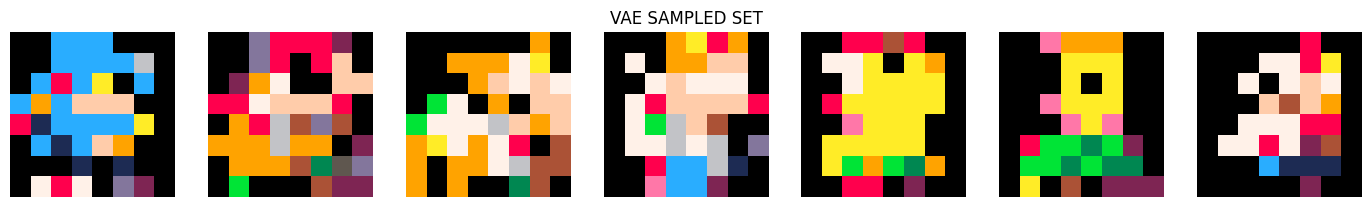

In [ ]:
# sample from this space and show output
sample_set = np.random.normal(0,1,size=(7,VAE_Z))

pred_samp_set = pico_vae_model.decoder.predict(sample_set,verbose=False)

showMultiSprPalette([decodeSpr1H(s) for s in pred_samp_set],text='VAE Sampled set')


In [ ]:
# export the model
if EXPORT_VAE:
    pico_vae_model.exportEnc(f'pico_vae-[{vae_dataset_type}]-{VAE_EPOCHS}')
    pico_vae_model.exportDec(f'pico_vae-[{vae_dataset_type}]-{VAE_EPOCHS}')

#### STUPID MODEL
Embedding to image model. That's it. Take a pretrained embedding network, train a model to output an image, that's it. Tim bet $25 this wouldn't work lmao

In [44]:
# IMPORT DOC2VEC

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
D2V_MODEL = Doc2Vec(documents, vector_size=128, window=2, min_count=1)

def wordEmb(txt):
    return D2V_MODEL.infer_vector(txt.split())

In [49]:
dewey = wordEmb("a duck with a blue hat")
huey = wordEmb("a duck with a red hat")
pikachu = wordEmb("a yellow electric mouse")

# get similarities between phrases by getting distances between word embeddings
print(f"COSINE SIM: {cos_sim([dewey,huey,pikachu])}")
print(f"EUCLIDEAN DIST: {[[np.linalg.norm(a-b) for a in [dewey,huey,pikachu]] for b in [dewey,huey,pikachu] ]}")


COSINE SIM: [[ 1.0000001  -0.1640559   0.07875782]
 [-0.1640559   0.9999997   0.02635097]
 [ 0.07875782  0.02635097  1.        ]]
EUCLIDEAN DIST: [[0.0, 0.039145034, 0.035064008], [0.039145034, 0.0, 0.034468196], [0.035064008, 0.034468196, 0.0]]


In [52]:
# IMPORT SENTENCE BERT
from sentence_transformers import SentenceTransformer
SBERT_MODEL = SentenceTransformer('bert-base-nli-mean-tokens')

def sentEmb(txt):
    return SBERT_MODEL.encode([txt])[0]

In [53]:
dewey = sentEmb("a duck with a blue hat")
huey = sentEmb("a duck with a red hat")
pikachu = sentEmb("a yellow electric mouse")

# get similarities between phrases by getting distances between word embeddings
print(f"COSINE SIM: {cos_sim([dewey,huey,pikachu])}")
print(f"EUCLIDEAN DIST: {[[np.linalg.norm(a-b) for a in [dewey,huey,pikachu]] for b in [dewey,huey,pikachu] ]}")

COSINE SIM: [[1.0000001  0.6279819  0.23689032]
 [0.6279819  1.0000001  0.32165208]
 [0.23689032 0.32165208 0.99999994]]
EUCLIDEAN DIST: [[0.0, 14.473851, 20.830334], [14.473851, 0.0, 19.58954], [20.830334, 19.58954, 0.0]]


Conclusion: Use Sentence Transformers with Cosine Similarity metric

#### Make a model trained on word embedding to image

a green dinosaur with red boots and a large nose


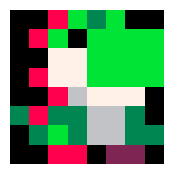

In [109]:
# import the labels for the PICO characters dataset
pico_char_labels = np.array([l.strip() for l in open('../data/rip_data/character_desc.txt','r').readlines()])

# check association match
rand_char_i = random.randint(0,len(pico_char_labels))
rand_char = pico_char_labels[rand_char_i]
rand_char_img = pico_char_dat[rand_char_i]
print(f"{rand_char}")
showSprPalette(rand_char_img)

In [110]:
# create the dataset (embheddings -> images)
pico_char_emb = SBERT_MODEL.encode(pico_char_labels)
pico_char_emb = np.array(pico_char_emb)

X_train = pico_char_emb
Y_train = np.array([encodeSpr1H(s) for s in pico_char_dat])

print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")

X_train: (100, 768)
Y_train: (100, 8, 8, 16)


In [125]:
# named after Tim's bet that this model was too simple lol
class FiveDollarModel(Model):
    def __init__(self,lv_shape,embedder=SBERT_MODEL):
        super(FiveDollarModel, self).__init__()
        self.embedder = embedder
        self.decoder = Sequential([
            InputLayer(input_shape=(lv_shape,)),
            # Dense(512,activation='relu'),
            Dense(256,activation='relu'),
            Reshape((2,2,64)),
            Conv2DTranspose(32, (2,2), strides=(2,2), padding='same', activation='relu'),
            Conv2DTranspose(16, (2,2), strides=(2,2), padding='same', activation='softmax')     # should output to a 8x8x16 one-hot encoded image
        ])
        
        self.decoder.summary()
        self.decoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # embeds the text and returns an image
    def txt2img(self,txt,uncode=True):
        emb = self.embedder.encode([txt])
        img = self.decoder.predict(np.array(emb),verbose=False)[0]
        if uncode:
            return decodeSpr1H(img)
        else:
            return img

In [139]:
# create and train the model
fdm = FiveDollarModel(X_train.shape[1])
fdm.decoder.fit(X_train,Y_train,epochs=150,verbose=1,shuffle=True,batch_size=16)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 256)               196864    
                                                                 
 reshape_23 (Reshape)        (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose_62 (Conv2D  (None, 4, 4, 32)         8224      
 Transpose)                                                      
                                                                 
 conv2d_transpose_63 (Conv2D  (None, 8, 8, 16)         2064      
 Transpose)                                                      
                                                                 
Total params: 207,152
Trainable params: 207,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
7/7 [==============================

a blue turtle standing up


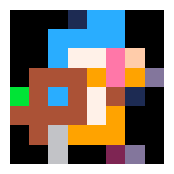

a woman with green hair


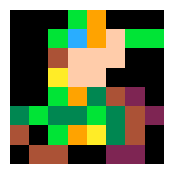

a duck with a yellow shirt


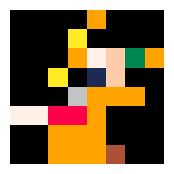

a white duck with a green outfit and a green hat


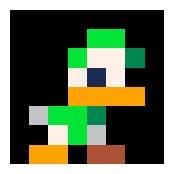

a yellow dog standing


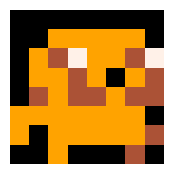

a man with a mustache and large pink nose dressed in yellow


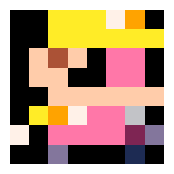

In [145]:
# test the model on unseen data
test_char_desc = ["a blue turtle standing up", "a woman with green hair", "a duck with a yellow shirt"]
seen_char_desc = random.sample(list(pico_char_labels), k=3)

for desc in test_char_desc:
    print(desc)
    showSprPalette(fdm.txt2img(desc))

for desc in seen_char_desc:
    print(desc)
    showSprPalette(fdm.txt2img(desc))

#### Sanity generalization check with pure shapes

In [181]:
#import from Python folder to get the utils
import sys
sys.path.append('../Python')
import utils

# import importlib
# importlib.reload(utils)


# import the shapes spritesheet
shapes_spr_dat = utils.picoSS2np('../data/rip_data/colors.png')

(64, 8, 8)
blue small square


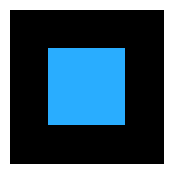

In [212]:
colors = ["red", "orange", "yellow", "green", "blue", "purple", "pink", "white"]
size = ["large", "small"]
shapes = ["square", "triangle", "circle", "line"]
squares = shapes_spr_dat[0:16]
triangles = shapes_spr_dat[16:32]
circles = shapes_spr_dat[32:48]
lines = shapes_spr_dat[48:64]

#label and encode
shape_imgs = np.concatenate([squares,triangles,circles,lines],axis=0)
print(shape_imgs.shape) #should be (64,8,8)
shape_imgs_1h = np.array([encodeSpr1H(s) for s in shape_imgs])
shape_labels = np.array([f"{c} {z} {s}" for s in shapes for z in size for c in colors])

rand_shape = random.randint(0,len(shape_labels))
print(f"{shape_labels[rand_shape]}")
showSprPalette(shape_imgs[rand_shape])

Test Set: [13, 16, 42, 51]


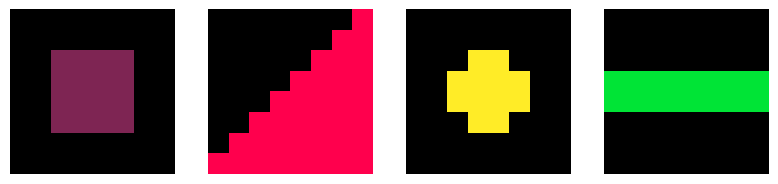

In [285]:
# train on the shapes (leave out some for testing)
test_index = []
for i in range(4):
    test_index.append(random.randint(i*16,(i+1)*16))
train_index = [i for i in range(len(shape_labels)) if i not in test_index]

X_shape_train = np.array([sentEmb(l) for l in shape_labels[train_index]])
Y_shape_train = shape_imgs_1h[train_index]

X_shape_test = shape_labels[test_index]
Y_shape_test = shape_imgs_1h[test_index]

print(f"Test Set: {test_index}")
showMultiSprPalette([decodeSpr1H(i) for i in Y_shape_test])

In [286]:
# like $5 model but bigger
class TenDollarModel(Model):
    def __init__(self,lv_shape,embedder=SBERT_MODEL):
        super(TenDollarModel, self).__init__()
        self.embedder = embedder
        self.decoder = Sequential([
            InputLayer(input_shape=(lv_shape,)),
            Dense(512,activation='relu'),
            Dense(256,activation='relu'),
            Dense(128,activation='relu'),
            Dense(64,activation='relu'),
            Reshape((1,1,64)),
            Conv2DTranspose(64, (2,2), strides=(2,2), padding='same', activation=LeakyReLU()),
            Conv2DTranspose(32, (2,2), strides=(2,2), padding='same', activation=LeakyReLU()),
            Conv2DTranspose(16, (2,2), strides=(2,2), padding='same', activation='softmax')     # should output to a 8x8x16 one-hot encoded image
        ])
        
        self.decoder.summary()
        self.decoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # embeds the text and returns an image
    def txt2img(self,txt,uncode=True):
        emb = self.embedder.encode([txt])
        img = self.decoder.predict(np.array(emb),verbose=False)[0]
        if uncode:
            return decodeSpr1H(img)
        else:
            return img

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 256)               196864    
                                                                 
 reshape_48 (Reshape)        (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose_124 (Conv2  (None, 4, 4, 32)         8224      
 DTranspose)                                                     
                                                                 
 conv2d_transpose_125 (Conv2  (None, 8, 8, 16)         2064      
 DTranspose)                                                     
                                                                 
Total params: 207,152
Trainable params: 207,152
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
8/8 [==============================

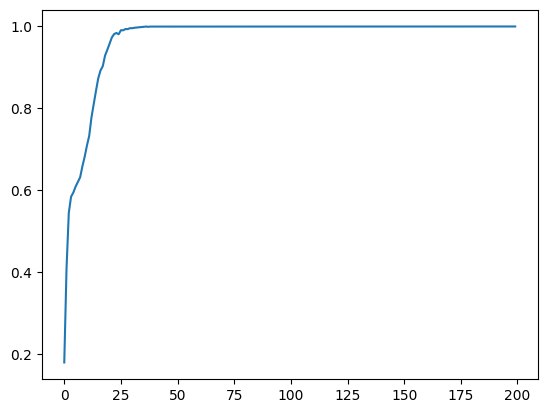

In [311]:
# train the model
# shape_tdm = TenDollarModel(X_shape_train.shape[1])
# acc = shape_tdm.decoder.fit(X_shape_train,Y_shape_train,epochs=100,verbose=1,shuffle=True,batch_size=8)
shape_tdm = FiveDollarModel(X_shape_train.shape[1])
acc = shape_tdm.decoder.fit(X_shape_train,Y_shape_train,epochs=200,verbose=1,shuffle=True,batch_size=8)

# plot the accuracy
plt.plot(acc.history['accuracy'])

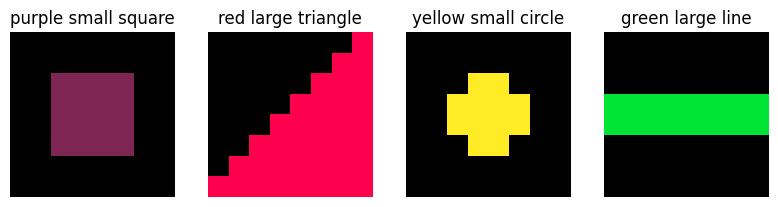

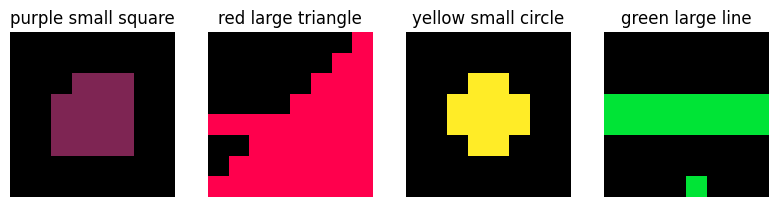

In [312]:
# show the results of the test set
showMultiSprPalette([decodeSpr1H(s) for s in Y_shape_test], textArr=X_shape_test.tolist())
showMultiSprPalette([shape_tdm.txt2img(desc) for desc in X_shape_test],textArr=X_shape_test.tolist())

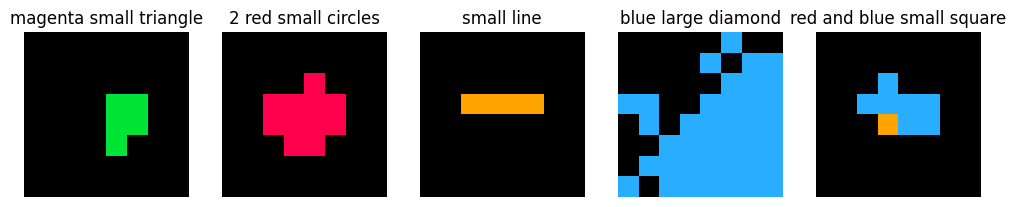

In [314]:
crazy_desc = ['magenta small triangle', '2 red small circles', 'small line', 'blue large diamond', 'red and blue small square']
showMultiSprPalette([shape_tdm.txt2img(desc) for desc in crazy_desc],textArr=crazy_desc)


#### Emoji Dataset Experiment

(8,)


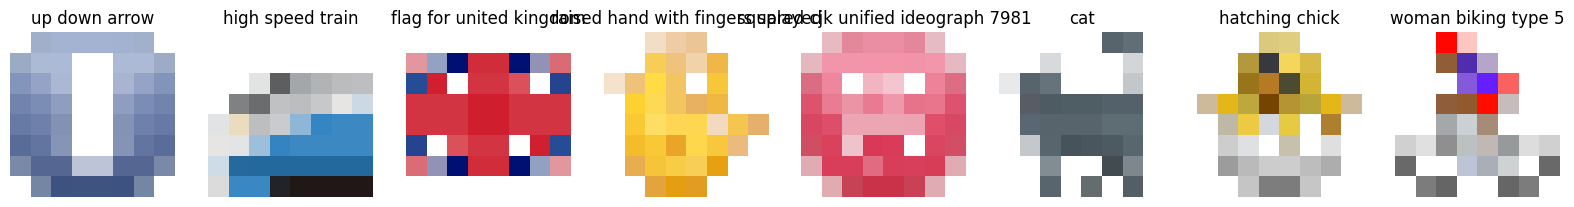

In [430]:
#import the icons dataset from numpy
icons50 = np.load('../data/sprite_data/icon_dat_rgb8.npy', allow_pickle=True)

randicons = icons50[random.sample(range(0,len(icons50)), k=8)]
print(randicons.shape)
showMultiSprRGB([i['img'] for i in randicons],textArr=[i['label'] for i in randicons])

In [333]:
# X_train = np.array([sentEmb(i['label']) for i in icons50])
# Y_train = np.array([(i['img'])/255 for i in icons50])

# print(Y_train.shape)  #nx8x8x1
from tqdm import tqdm


with tqdm(total=len(icons50)) as pbar:
    X_train = []
    Y_train = []
    for i in icons50:
        X_train.append(sentEmb(i['label']))
        Y_train.append((i['img'])/255)
        pbar.update(1)


100%|██████████| 10000/10000 [10:04<00:00, 16.53it/s]


In [334]:
X_icons_train = np.array(X_train)
Y_icons_train = np.array(Y_train)

print(X_icons_train.shape)
print(Y_icons_train.shape)

(10000, 768)
(10000, 8, 8, 3)


In [543]:
# outputs  8X8 RGB image
# from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

from keras.layers import BatchNormalization

class ThreeDollarModel(Model):
    def __init__(self,lv_shape,embedder=SBERT_MODEL):
        super(ThreeDollarModel, self).__init__()
        self.embedder = embedder
        self.decoder = Sequential([
            
            # ORIGINAL MODEL

            # InputLayer(input_shape=(lv_shape,)),
            # # Dense(512,activation='relu'),
            # Dense(128,activation='relu'),
            # Reshape((1,1,128)),
            # # Conv2DTranspose(128, (2,2), strides=(2,2), padding='same', activation='relu'),
            # Conv2DTranspose(64, (2,2), strides=(2,2), padding='same', activation='relu'),
            # Conv2DTranspose(32, (2,2), strides=(2,2), padding='same', activation='relu'),
            # Conv2DTranspose(3, (2,2), strides=(2,2), padding='same', activation='sigmoid')     # should output to a 8x8x3 image

            InputLayer(input_shape=(lv_shape,)),
            Dense(256,activation=LeakyReLU(alpha=0.2)),
            Reshape((1,1,256)),

            #upsample to 2x2
            Conv2DTranspose(128, (2,2), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2)),
            BatchNormalization(),

            #upsample to 4x4
            Conv2DTranspose(128, (2,2), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2)),
            BatchNormalization(),

            #upsample to 8x8
            Conv2DTranspose(128, (2,2), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2)),
            BatchNormalization(),

            #output
            Conv2D(3, (3,3), strides=(1,1), padding='same', activation='sigmoid')     # should output to a 8x8x3 image

        ])
        
        self.decoder.summary()
        self.opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.decoder.compile(optimizer=self.opt, loss='mse', metrics=['accuracy'])

        # self.decoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])  # mse just turns everything white and collapses

    # embeds the text and returns an image
    def txt2img(self,txt,uncode=True):
        emb = self.embedder.encode([txt])
        img = self.decoder.predict(np.array(emb),verbose=False)[0]
        if uncode:
            return decodeSpr1H(img)
        else:
            return img
        
    def exportModel(self,name='icon_gen'):
        self.decoder.save(f'../models/gen_models/dollars/{name}.h5')

    def importModel(self,name='icon_gen'):
        self.decoder = load_model(f'../models/gen_models/dollars/{name}.h5')

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_111 (Dense)           (None, 256)               196864    
                                                                 
 reshape_79 (Reshape)        (None, 1, 1, 256)         0         
                                                                 
 conv2d_transpose_217 (Conv2  (None, 2, 2, 128)        131200    
 DTranspose)                                                     
                                                                 
 batch_normalization_12 (Bat  (None, 2, 2, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_218 (Conv2  (None, 4, 4, 128)        65664     
 DTranspose)                                                     
                                                     

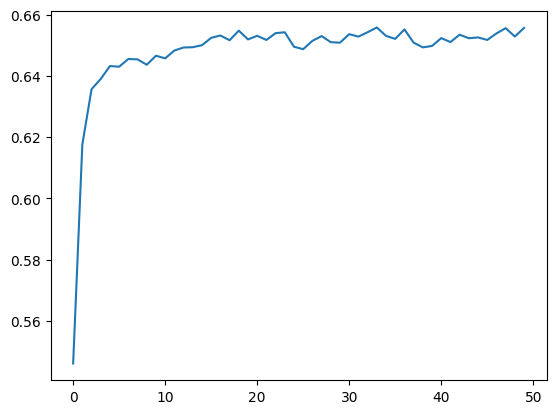

In [434]:
icons_tdm = ThreeDollarModel(X_icons_train.shape[1])
acc_ic = icons_tdm.decoder.fit(X_icons_train,Y_icons_train,epochs=50,verbose=1,shuffle=True,batch_size=32)

# plot the accuracy
plt.plot(acc_ic.history['accuracy'])

Epoch 1/100
313/313 [==============================] - 9s 28ms/step - loss: 0.2573 - accuracy: 0.6293
Epoch 2/100
313/313 [==============================] - 8s 27ms/step - loss: 0.2573 - accuracy: 0.6295
Epoch 3/100
313/313 [==============================] - 9s 29ms/step - loss: 0.2573 - accuracy: 0.6301
Epoch 4/100
313/313 [==============================] - 10s 32ms/step - loss: 0.2573 - accuracy: 0.6293
Epoch 5/100
313/313 [==============================] - 9s 28ms/step - loss: 0.2573 - accuracy: 0.6275
Epoch 6/100
313/313 [==============================] - 9s 27ms/step - loss: 0.2573 - accuracy: 0.6306
Epoch 7/100
313/313 [==============================] - 9s 28ms/step - loss: 0.2573 - accuracy: 0.6315
Epoch 8/100
313/313 [==============================] - 10s 32ms/step - loss: 0.2573 - accuracy: 0.6306
Epoch 9/100
313/313 [==============================] - 9s 28ms/step - loss: 0.2573 - accuracy: 0.6291
Epoch 10/100
313/313 [==============================] - 9s 28ms/step - loss: 0.2

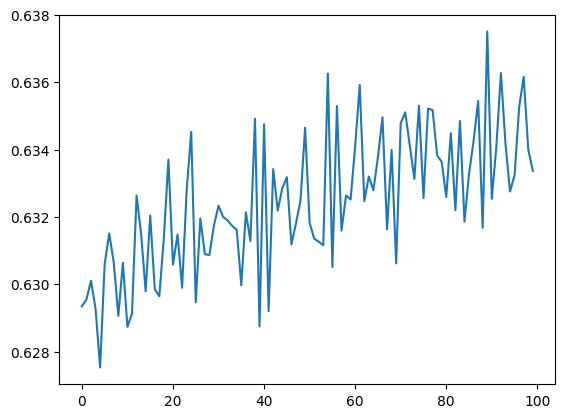

In [431]:
# extended training
acc_ic2 = icons_tdm.decoder.fit(X_icons_train,Y_icons_train,epochs=100,verbose=1,shuffle=True,batch_size=32)

# plot more
plt.plot(acc_ic2.history['accuracy'])

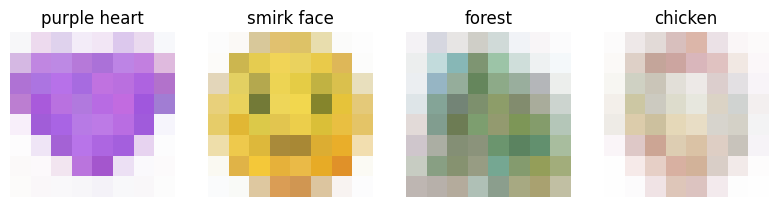

In [436]:
fave_emojis = ["purple heart", "smirk face", "forest", "chicken"]
RGB_OUT = []
for desc in fave_emojis:
    img = icons_tdm.txt2img(desc,False)
    #un-normalize the image
    img = (img*255).astype(np.uint8)
    RGB_OUT.append(img)

showMultiSprRGB(RGB_OUT,textArr=fave_emojis)

In [426]:
user_in = input("Enter a description of an emoji: ")
while user_in != 'q':
    img = icons_tdm.txt2img(user_in,False)
    #un-normalize the image
    img = (img*255).astype(np.uint8)
    showMultiSprRGB([img],textArr=[user_in])
    user_in = input("Enter a description of an emoji: ")

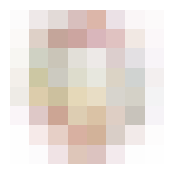

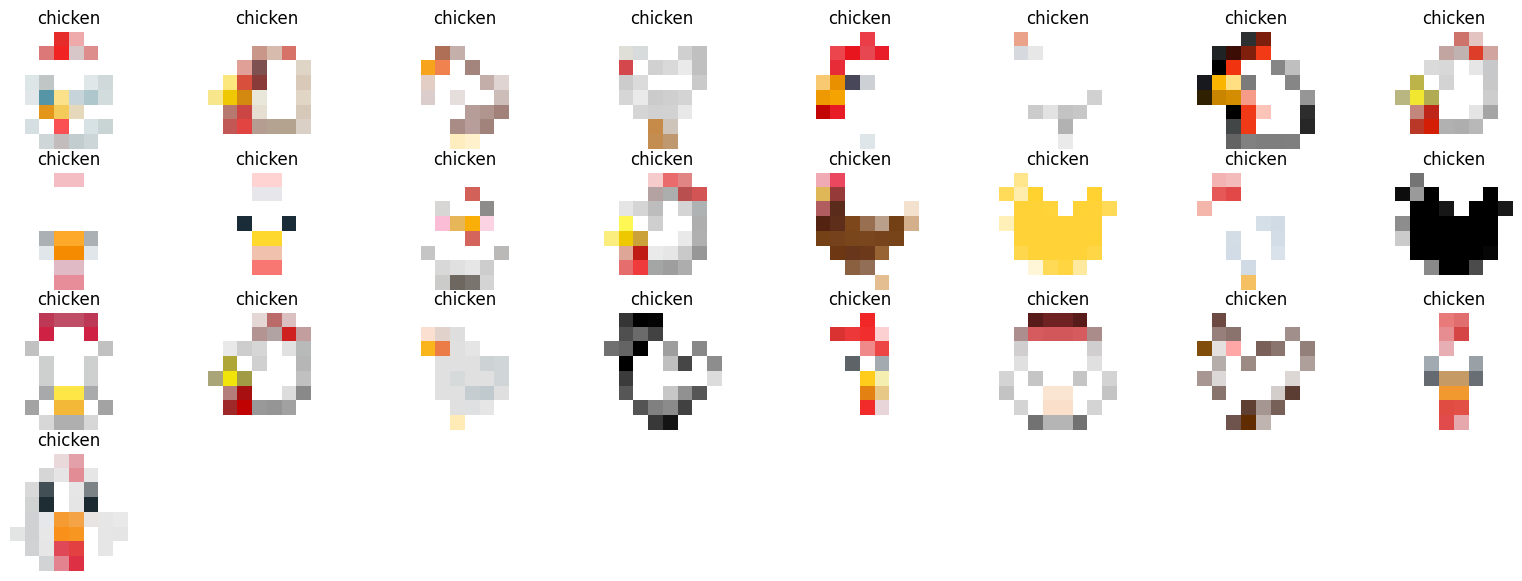

In [636]:
SPEC_EMOJI = "chicken"

#show output from model first
img = icons_tdm.txt2img(SPEC_EMOJI,False)
#un-normalize the image
img = (img*255).astype(np.uint8)
showSprRGB(img)

all_chickens = []
for i in icons50:
    ss = SPEC_EMOJI.split()
    f = 0
    for s in ss:
        if s not in i['label']:
            f = 1
            break
    if f == 0:
        all_chickens.append((i['img'],i['label']))
    

# all_chickens = [(i['img'],i['label']) for i in icons50 if SPEC_EMOJI ]

if len(all_chickens) == 0:
    print("No chickens found")

if len(all_chickens) > 32:
    for i in range(0,len(all_chickens),32):
        showMultiSprRGB([i[0] for i in all_chickens[i:i+32]],textArr=[i[1] for i in all_chickens[i:i+32]])
else:
    showMultiSprRGB([i[0] for i in all_chickens],textArr=[i[1] for i in all_chickens])

63


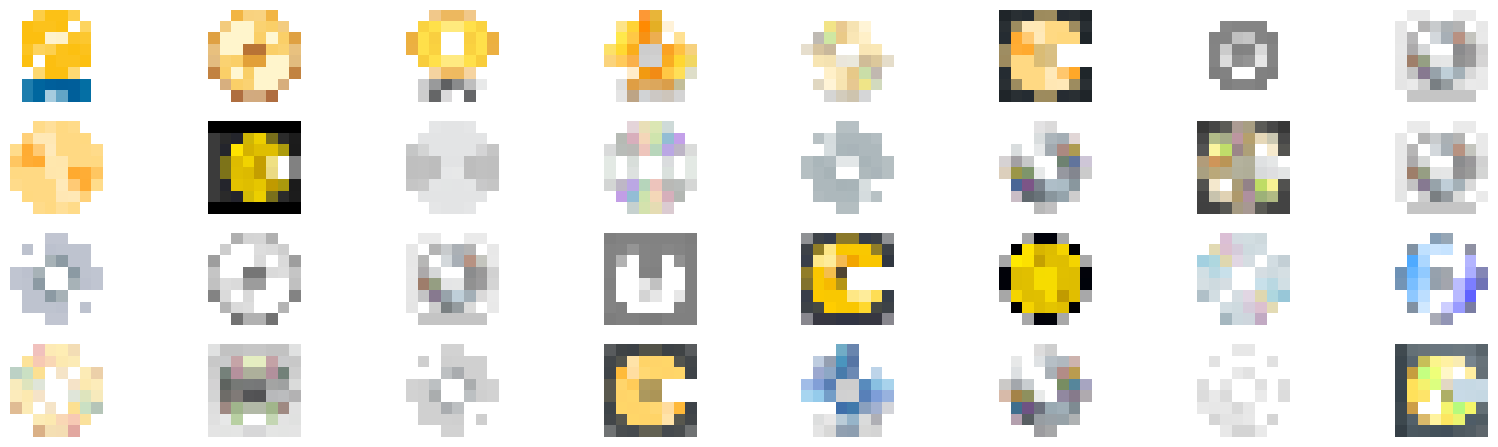

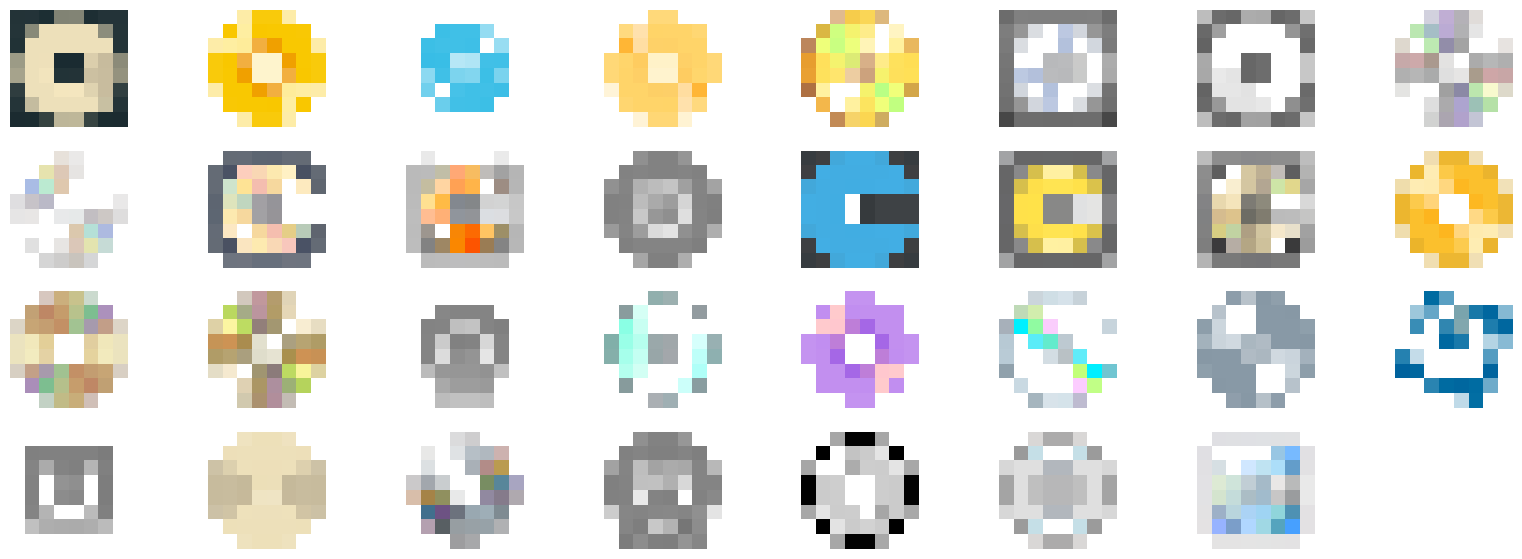

In [506]:
all_planes = [i['img'] for i in icons50 if "disk" in i['class']]
print(len(all_planes))

for i in range(0,len(all_planes),32):
    showMultiSprRGB(all_planes[i:i+32])

### Fix the bullshit icons dataset

In [513]:
uniq_icons = []
uniq_labels = []
for i in icons50:
    if i['label'] not in uniq_labels:
        uniq_icons.append(i['img'])
        uniq_labels.append(i['label'])

print(len(uniq_icons))

568


In [515]:
suniq_labels = sorted(uniq_labels)
print(suniq_labels)

['airplane', 'airplane arriving', 'airplane departure', 'alarm clock', 'ambulance', 'american football', 'angry face', 'anguished face', 'anticlockwise downwards and upwards open circle arrows', 'arrow pointing rightwards then curving downwards', 'arrow pointing rightwards then curving upwards', 'asterisk', 'athletic shoe', 'automobile', 'baby bottle', 'baby chick', 'banknote with dollar sign', 'banknote with euro sign', 'banknote with pound sign', 'banknote with yen sign', 'baseball', 'basketball and hoop', 'beach with umbrella', 'beating heart', 'beer mug', 'billed cap', 'billiards', 'bird', 'black heart', 'black heart suit', 'black nib', 'black rightwards arrow', 'black scissors', 'blossom', 'blowfish', 'blue book', 'blue heart', 'bookmark', 'bookmark tabs', 'books', 'bouquet', 'broken heart', 'bus', 'canoe', 'carp streamer', 'cat', 'cat face', 'cat face with tears of joy', 'cat face with wry smile', 'chequered flag', 'cherry blossom', 'chicken', 'christmas tree', 'circled ideograph

In [517]:

with tqdm(total=len(uniq_icons)) as pbar:
    X_uicons_train = []
    Y_uicons_train = []
    for i in range(len(uniq_icons)):
        X_uicons_train.append(sentEmb(uniq_labels[i]))
        Y_uicons_train.append((uniq_icons[i])/255)
        pbar.update(1)

    #convert to np
    X_uicons_train = np.array(X_uicons_train)
    Y_uicons_train = np.array(Y_uicons_train)


100%|██████████| 568/568 [00:39<00:00, 14.30it/s]


Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_115 (Dense)           (None, 256)               196864    
                                                                 
 reshape_83 (Reshape)        (None, 1, 1, 256)         0         
                                                                 
 conv2d_transpose_229 (Conv2  (None, 2, 2, 128)        131200    
 DTranspose)                                                     
                                                                 
 batch_normalization_24 (Bat  (None, 2, 2, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_230 (Conv2  (None, 4, 4, 128)        65664     
 DTranspose)                                                     
                                                     

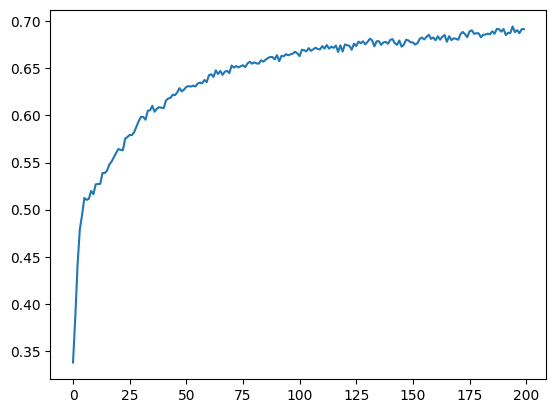

In [544]:
# retrain model on unique icons
uicons_tdm = ThreeDollarModel(X_uicons_train.shape[1])
acc_uic = uicons_tdm.decoder.fit(X_uicons_train,Y_uicons_train,epochs=200,verbose=1,shuffle=True,batch_size=32)

# plot the accuracy
plt.plot(acc_uic.history['accuracy'])

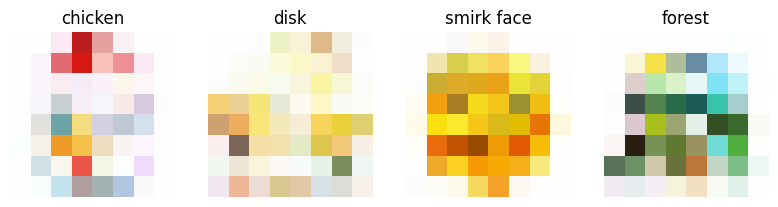

In [550]:
fave_emojis = ["chicken", "disk", "smirk face", "forest"]
RGB_OUT = []
for desc in fave_emojis:
    img = uicons_tdm.txt2img(desc,False)
    #un-normalize the image
    img = (img*255).astype(np.uint8)
    RGB_OUT.append(img)

showMultiSprRGB(RGB_OUT,textArr=fave_emojis)

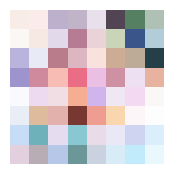

No chickens found


<Figure size 2000x700 with 0 Axes>

In [554]:
SPEC_EMOJI = "rainbow"

#show output from model first
img = uicons_tdm.txt2img(SPEC_EMOJI,False)
#un-normalize the image
img = (img*255).astype(np.uint8)
showSprRGB(img)

all_chickens = []
for i in range(len(uniq_icons)):
    ss = SPEC_EMOJI.split()
    f = 0
    for s in ss:
        if s not in uniq_labels[i]:
            f = 1
            break
    if f == 0:
        all_chickens.append((uniq_icons[i],uniq_labels[i]))
    

# all_chickens = [(i['img'],i['label']) for i in icons50 if SPEC_EMOJI ]

if len(all_chickens) == 0:
    print("No chickens found")

if len(all_chickens) > 32:
    for i in range(0,len(all_chickens),32):
        showMultiSprRGB([i[0] for i in all_chickens[i:i+32]],textArr=[i[1] for i in all_chickens[i:i+32]])
else:
    showMultiSprRGB([i[0] for i in all_chickens],textArr=[i[1] for i in all_chickens])

#### PATH OF DESTRUCTION

### ALGORITHM

TRAINING
1. Generate a noisy sprite
2. Choose the closest goal sprite from the training data (hamming distance)
3. Destroy the goal sprite (sequentially over pixles) until it matches the noisy sprite
4. Add the level repair step to the training data
5. Repeat until it matches the noise

---

GENERATION 
1. Initialize a noisy sprite
2. Randomly or sequentially pick/fix a pixel
3. Feed the level into the network to output a repair value
4. Update the pixel with the value
5. If the current sprite isn't valid, keep going

#### Normal PoD (no text embedding)

In [722]:
class NormalPoD():
    def __init__(self,spr_shape, channels=16, pad_val=0, crop_size=5):
        self.destroy_data = []
        self.spr_shape = spr_shape
        self.channels = channels
        self.pad_val = pad_val
        self.crop_size = crop_size

    # make a new noisy sprite using the channels and size
    def init_noise_sprite(self):
        noise_spr = np.random.randint(self.channels,size=(self.spr_shape[0],self.spr_shape[1]))
        return noise_spr

    # crop a sprite from the noise sprite (use with padding) - assume pos is (x,y) and center of target crop
    def crop(self, spr, pos, size=5):
        hpad = size//2
        pad_spr = np.pad(spr,((hpad,hpad),(hpad,hpad)),constant_values=self.pad_val)   # pad the sprite 
        crop_spr = pad_spr[pos[1]:pos[1]+size,pos[0]:pos[0]+size]   # get the cropped sprite (should be size,size)
        return pad_spr, crop_spr

    # return the new level and the tile replaced (also add to training data) - assume pos is (x,y)
    def destroy(self, cur_spr, bad_spr, pos, crop_size=5):
        # turn the cur_spr value at the pos to the bad_spr value
        cur_spr2 = np.copy(cur_spr)
        og_val = cur_spr[pos[0],pos[1]]
        cur_spr2[pos[0],pos[1]] = bad_spr[pos[0],pos[1]]

        # crop around the area and add to training data
        _, crop_spr = self.crop(cur_spr2,pos,crop_size)

        return cur_spr2, og_val, crop_spr
    
    # calculate the hamming distance from 2 sprites
    def calc_ham_dist(self, spr1, spr2):
        return np.sum(spr1 != spr2)

    # return the sprite that is closest in hamming distance from the goal set
    def closest_spr(self, goal_set, noise_spr):
        min_dist_i = np.argmin([self.calc_ham_dist(noise_spr, i) for i in goal_set])
        return goal_set[min_dist_i]

    
    # make the training data for the path of destruction
    def make_train_dat(self,goal_set,num_noise_spr=1000):
        train_dat = []
        with tqdm(total=num_noise_spr) as pbar:
            for i in range(num_noise_spr):
                # make a noise sprite and find the closest
                noise_spr = self.init_noise_sprite()
                targ_spr = self.closest_spr(goal_set,noise_spr)

                # iterate over the goal sprite and change until it matches the noise spr (destroy)
                for y in range(self.spr_shape[0]):
                    for x in range(self.spr_shape[1]):
                        # destroy the noise sprite
                        noise_spr, og_val, crop_spr = self.destroy(noise_spr,targ_spr,(x,y),self.crop_size)
                        train_dat.append([crop_spr,og_val])
                pbar.update(1)
                    
        return train_dat
    
    # make the path of destruction neural network model
    # copy of architecture from the paper [Conv(128,3) -> Conv(128,3) -> MaxPool(2), Conv(256,3)]
    # it doesn't work though... at least not with 5x5 crop size - need to ask Sam for exact implementation
    def makePoDCNN(self):
        self.pod_model = Sequential([
            InputLayer(input_shape=(self.crop_size,self.crop_size,1)),
            # Conv2D(128, (3, 3), activation='relu'),
            # Conv2D(128, (3, 3), activation='relu'),
            Conv2D(256, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Dense(self.channels,activation='softmax'),
        ])
        self.pod_model.summary()
        self.opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        self.pod_model.compile(optimizer=self.opt,metrics=['accuracy'],loss='sparse_categorical_crossentropy') #not one-hot encoded
        

    # train the path of destruction model on the training data
    def trainPoD(self,train_dat,EPOCHS=500,BATCH_SIZE=64,show_acc=False):
        # train the model
        X = np.array([i[0] for i in train_dat])
        Y = np.array([i[1] for i in train_dat])
        X = np.expand_dims(X,axis=-1)
        Y = np.expand_dims(Y,axis=-1)
        print(X.shape,Y.shape)

        h = self.pod_model.fit(X,Y,epochs=EPOCHS,batch_size=BATCH_SIZE,shuffle=True)
        if show_acc:
            plt.plot(h.history['accuracy'])
            plt.show()


# Make the Path of Destruction  model
npod = NormalPoD((8,8),channels=16)     
npod.makePoDCNN() 

Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 3, 3, 256)         2560      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 1, 1, 256)        0         
 g2D)                                                            
                                                                 
 dense_143 (Dense)           (None, 1, 1, 16)          4112      
                                                                 
Total params: 6,672
Trainable params: 6,672
Non-trainable params: 0
_________________________________________________________________


In [718]:
# make the training data
goal_spr_char = pico_char_dat.copy()
print(goal_spr_char.shape)
train_dat = npod.make_train_dat(goal_spr_char,num_noise_spr=1000)
print(len(train_dat))

(100, 8, 8)


100%|██████████| 1000/1000 [00:06<00:00, 158.54it/s]

64000


In [725]:
X = np.array([i[0] for i in train_dat])
Y = np.array([i[1] for i in train_dat])

print(X[0])
print(Y[0])

[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  4  2]
 [ 0  0  4 14 14]
 [ 0  0 11 12  9]]
7


In [726]:
npod.trainPoD(train_dat,EPOCHS=500,BATCH_SIZE=64,show_acc=True)

(64000, 5, 5, 1) (64000, 1)
Epoch 1/500
1000/1000 [==============================] - 2s 1ms/step - loss: 2.7979 - accuracy: 0.0627
Epoch 2/500
1000/1000 [==============================] - 1s 1ms/step - loss: 2.7752 - accuracy: 0.0632
Epoch 3/500
1000/1000 [==============================] - 1s 1ms/step - loss: 2.7733 - accuracy: 0.0621
Epoch 4/500
1000/1000 [==============================] - 1s 1ms/step - loss: 2.7720 - accuracy: 0.0625
Epoch 5/500
1000/1000 [==============================] - 1s 1ms/step - loss: 2.7711 - accuracy: 0.0628
Epoch 6/500
1000/1000 [==============================] - 1s 1ms/step - loss: 2.7706 - accuracy: 0.0625
Epoch 7/500
1000/1000 [==============================] - 1s 1ms/step - loss: 2.7703 - accuracy: 0.0623
Epoch 8/500
1000/1000 [==============================] - 1s 1ms/step - loss: 2.7694 - accuracy: 0.0628
Epoch 9/500
1000/1000 [==============================] - 1s 1ms/step - loss: 2.7688 - accuracy: 0.0626
Epoch 10/500
1000/1000 [=====================

KeyboardInterrupt: 

In [ ]:
# show 